# Stupid Tensorflow Tricks, II
Solving an old physics problem with Tensorflow!
_part one [here](https://towardsdatascience.com/stupid-tensorflow-tricks-3a837194b7a0)_ 

## Brachistocrone problem
What's the fastest way down a ramp? Let's solve for the height of the green dots that minimize the time.

![](figures/plane.png)

In [1]:
import tensorflow as tf
import numpy as np
print(tf.__version__)

# This lets us see computations as soon as we run them!
tf.enable_eager_execution()

1.14.0


In [2]:
# Setup the "ramp"
N = 20
width = 3
y = tf.Variable(np.linspace(0.99, 0.01, N,), dtype=tf.float32)
x = tf.linspace(0.0, 1.0, N+2) * width
print(y)

<tf.Variable 'Variable:0' shape=(20,) dtype=float32, numpy=
array([0.99      , 0.9384211 , 0.88684213, 0.83526313, 0.7836842 ,
       0.73210526, 0.6805263 , 0.6289474 , 0.57736844, 0.5257895 ,
       0.47421053, 0.4226316 , 0.37105262, 0.31947368, 0.26789474,
       0.21631579, 0.16473684, 0.1131579 , 0.06157895, 0.01      ],
      dtype=float32)>


### Conservation of Energy
$$U=K$$
$$mgh = \frac{1}{2}mv^2$$
$$v = \sqrt{2gh}$$

In [3]:
g = tf.constant(9.8)
v = tf.sqrt(2 * g * (1 - y));
print(v)

tf.Tensor(
[0.44271865 1.0986114  1.4892597  1.7968982  2.059075   2.2914488
 2.5023358  2.6967816  2.8781204  3.0486925  3.2102141  3.3639889
 3.5110354  3.652166   3.7880425  3.9192102  4.0461287  4.169185
 4.2887125  4.4049973 ], shape=(20,), dtype=float32)


# Time to roll down 
can compute for each little segment...
$$ z(t) = z_0 + v_0 t + \frac{1}{2}a_z t^2 = z_0 + v_0 t + \frac{g \sin(\theta) t^2}{2} $$


$$ t = \frac{-v_0 \pm \sqrt{v_0^2 - 2 g \sin(\theta)z_0}} {g \sin(\theta)} $$

Ugh. We have to keep track of the root: the first root if going up the ramp, the second root if we are moving up the ramp.

... that's stupid and too much work. 

## Lazy physics ...
Over a short enough time span we can ignore gravity, as long as we fix the velocity each segment.

$$ z(t) = z_0 + v_0 t $$
$$ t = z_0 / v_0  $$

The change along the ramp:

![](figures/plane_crop.png)

$$ t = \frac{\sqrt{\Delta x^2 + \Delta y^2}}{v_0}  $$

In [4]:
dx = x[1] - x[0]
dy = y[:-1] - y[1:]
dz = tf.sqrt(dx ** 2 + dy ** 2)
print(dz)

tf.Tensor(
[0.15188335 0.15188335 0.15188336 0.15188335 0.15188335 0.15188335
 0.15188335 0.15188335 0.15188335 0.15188335 0.15188335 0.15188335
 0.15188335 0.15188335 0.15188335 0.15188335 0.15188335 0.15188335
 0.15188335], shape=(19,), dtype=float32)


Let's clean it up, and encapsulate it all in a function.

In [5]:
def compute_ramp(y):
    g = tf.constant(9.8)
    
    # Fix the endpoints
    y = tf.concat([[1.0], y, [0.0]], axis=0)
    
    # All the widths are the same
    dx = x[1] - x[0]
    dy = y[:-1] - y[1:]   
    dz = tf.sqrt(dx ** 2 + dy ** 2)

    # Convervation of energy
    v = tf.sqrt(2 * g * (y[0] - y))
    
    # The average of the starting and ending velocity at each segment
    avg_v = (v[1:] + v[:-1]) / 2

    total_time = tf.reduce_sum(dz / avg_v)
    return total_time

In [6]:
# For a 3x1 ramp, this should be ~ 1.34s
print(compute_ramp(y).numpy())

1.8699452


In [7]:
# Oof. Let's try it with more points!
N = 2000
width = 3
y = tf.Variable(np.linspace(0.90, 0,N,), dtype=tf.float32)
x = tf.linspace(0.0, 1.0, N+2) * width
print(compute_ramp(y).numpy())

1.2172186


In [8]:
# Develop our training step
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)

def train_step(y):
    with tf.GradientTape() as tape:
        time = compute_ramp(y)

    variables = [y]
    grads = tape.gradient(time, variables)
    optimizer.apply_gradients(zip(grads, variables))

    return time.numpy()

In [9]:
%%capture
import pylab as plt
import seaborn as sns
import matplotlib.pylab as plt

fig, ax = plt.subplots(figsize=(7,4))
plt.rcParams['figure.dpi'] = 125

In [10]:
N = 500
width = 3
n_steps = 5000

y = tf.Variable(np.random.uniform(-1,0.5,size=(N,)), dtype=tf.float32)
x = tf.linspace(0.0, 1.0, N+2) * width

for i in range(n_steps):
    t = train_step(y)

    if i % 100 == 0 and i > 0:
        print(f"{i} {t:0.16f}")
        yx = np.hstack([[1], y.numpy(), [0]])
        ax.plot(x.numpy(), yx, color='b',alpha=i/n_steps)

W0901 16:36:15.191475 140389145937664 deprecation.py:323] From /home/travis/.pyenv/versions/3.7.0/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100 2.1220104694366455
200 1.1325756311416626
300 1.1052708625793457
400 1.0943330526351929
500 1.0873215198516846
600 1.0820394754409790
700 1.0773720741271973
800 1.0730873346328735
900 1.0689598321914673
1000 1.0653016567230225
1100 1.0614326000213623
1200 1.0579665899276733
1300 1.0542386770248413
1400 1.0513039827346802
1500 1.0482250452041626
1600 1.0447452068328857
1700 1.0423129796981812
1800 1.0393537282943726
1900 1.0371962785720825
2000 1.0347702503204346
2100 1.0326133966445923
2200 1.0320587158203125
2300 1.0289803743362427
2400 1.0424745082855225
2500 1.0284521579742432
2600 1.0269663333892822
2700 1.0273648500442505
2800 1.0266393423080444
2900 1.0276639461517334
3000 1.0265601873397827
3100 1.0259170532226562
3200 1.0243619680404663
3300 1.0257209539413452
3400 1.0246456861495972
3500 1.0265769958496094
3600 1.0246373414993286
3700 1.0240087509155273
3800 1.0235447883605957
3900 1.0239084959030151
4000 1.0244286060333252
4100 1.0237576961517334
4200 1.0229823589324951
4

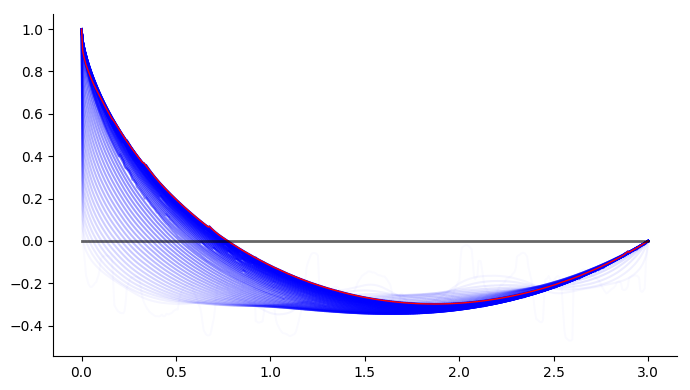

In [11]:
ax.plot(x.numpy(), yx,'r',lw=1)
ax.plot(x.numpy(), 0*x.numpy(),'k',lw=2,alpha=0.6)
sns.despine(ax=ax)
fig.tight_layout()   
fig

## Wikipedia solution to the [Brachistochrone](https://en.wikipedia.org/wiki/Brachistochrone_curve)
![](figures/Brachistochrone.gif)
we did pretty well!